# <center>Машинное обучение</center>
<center><small>Домашнее задание 3</small></center>
<center><i>Решетников Андрей, 397 группа</i></center>

# Задание 1

При жадном обучении решающих деревьев на каждом шаге выбирается разбиение, максимизирующее величину:
$$ \Delta = F(X, Y) - \frac{(X_1,Y_1)}{(X, Y)}\cdot H(X_1, Y_1) - \frac{(X_2, Y_2)}{(X, Y)} \cdot H(X_2, Y_2) $$
где $(X,Y)$ выборка в исходной вершине, где $(X_1,Y_1)$, $(X_2,Y_2)$ - выборки в вершинах-потомках, а функция $H(X,Y)$ - некоторая мера неоднородности выборки $(X,Y)$

Общепринятыми функциями являются:
 $$ 1.\ H(X, Y) = - \sum_{y_i\in Y}p_{y_i}\log(p_{y_i}) - энтропия$$ 
 $$ 2.\ H(X, Y) = 1 - \sum_{y_i\in Y}p_{y_i}^2 - индекс Джини$$ 
 $$ 3.\ H(X, Y) = 1 - \max {p_{y_i}} - вероятность ошибочной классификации$$ 

In [25]:
from numpy import *

def entropy(x):
    chance = [value / sum(x) for value in x]
    return sum(-p * log2(p) for p in chance)

def giney_index(x):
    chance = [value / sum(x) for value in x]
    return 1 - sum(p ** 2 for p in chance)

def chance_error_classification(x):
    chance = [value / sum(x) for value in x]
    return 1 - max(chance)

def delta(x, y, func):
    S1 = sum(x)
    S2 = sum(y)
    S = S1 + S2
    return - S1 / S * func(x) - S2 / S * func(y)

На первом шаге из 3 случаев, у нас всего 2 варианта разбиения

Для энтропии:

In [26]:
print(delta([200], [100, 100, 100, 100], entropy), delta([200, 100], [100, 100, 100], entropy))

-1.33333333333 -1.25162916739


Индекс Джини:

In [27]:
print(delta([200], [100, 100, 100, 100], giney_index), delta([200, 100], [100, 100, 100], giney_index))

-0.5 -0.555555555556


Вероятность ошибочной классификации:

In [28]:
print(delta([200], [100, 100, 100, 100], chance_error_classification), delta([200, 100], [100, 100, 100], chance_error_classification))

-0.5 -0.5


Заметим, что случай с энтропией лучше для второго разбиения, значит картинка 3 относится к энтропии
Проделаем то же самое для второго шага, для разбиений [100, 50, 50]:[50, 50, 100] и [95, 80, 20, 5]:[5, 20, 80, 95]

Индекс Джини:

In [29]:
print(delta([100, 50, 50], [50, 50, 100], giney_index), delta([95, 80, 20, 5], [5, 20, 80, 95], giney_index))

-0.625 -0.60375


Вероятность ошибочной классификации:

In [30]:
print(delta([100, 50, 50], [50, 50, 100], chance_error_classification), delta([95, 80, 20, 5], [5, 20, 80, 95], chance_error_classification))

-0.5 -0.525


В итоге индекс Джини - второе разбиение, ошибочная классификация - первое

# Задание 2

Псевдокод с семинара:

In [37]:
"""
GA with only mutations --> Stochastic Search (T mutations over individual)
B=1 --> Stochastic Local Search

Adaptation (idea): to increase probability of good features and to decrease probability of bad ones.

Algorithm:
1. p_1 = .. = p_n = 1 / n (feature uniform distribution)
2. for j in j_0 .. n: (feature set size)
3.     for t in 1..T: (iteration count)
4.         F_j = generate r feature sets of size j based on (p_1,...,p_n) distribution
5.         F_worse = argmax_{S \in F_j} Q(S) (worse)
           F_best = argmax_{S \in F_j} Q(S) (best)
6.         H = 0 (delta)
           for f_i in F_worse:
               p_delta = min(p_i, h)
               p_i -= p_delta
               H += p_delta
           for f_i in F_best:
               p_i += H / j
7.      j* = argmin_{s <= j} Q(F_s)
8.      if j - j* >= d:
            return F_j*

Degrees of freedom:
* r (level of significance 0.05 -> 39, 0.1 -> 19. Analogy with ShuffleSplit)
* T (iteration count: 10-50)
* h (degree of adaptation: try to skip zero probabilities, e.g. (1 - p_min) / rn)

Pro:
* Should be better than AddDel (in quality)
* Convergence speeds up with adaptation
"""

'\nGA with only mutations --> Stochastic Search (T mutations over individual)\nB=1 --> Stochastic Local Search\n\nAdaptation (idea): to increase probability of good features and to decrease probability of bad ones.\n\nAlgorithm:\n1. p_1 = .. = p_n = 1 / n (feature uniform distribution)\n2. for j in j_0 .. n: (feature set size)\n3.     for t in 1..T: (iteration count)\n4.         F_j = generate r feature sets of size j based on (p_1,...,p_n) distribution\n5.         F_worse = argmax_{S \\in F_j} Q(S) (worse)\n           F_best = argmax_{S \\in F_j} Q(S) (best)\n6.         H = 0 (delta)\n           for f_i in F_worse:\n               p_delta = min(p_i, h)\n               p_i -= p_delta\n               H += p_delta\n           for f_i in F_best:\n               p_i += H / j\n7.      j* = argmin_{s <= j} Q(F_s)\n8.      if j - j* >= d:\n            return F_j*\n\nDegrees of freedom:\n* r (level of significance 0.05 -> 39, 0.1 -> 19. Analogy with ShuffleSplit)\n* T (iteration count: 10-50)\

In [31]:
import numpy as np

def SLS(estimator, X_train, Y_train, X_test, Y_test, r, T, h, d):
    global_current_best_score = 0 
    global_current_best_set = []
    n = X_train.shape[1] 
    p = [1 / n] * n 
    non_change = 0
    for index_j in range(1, n + 1):
        local_current_best_set = []
        local_current_best_score = 0
        for index_t in range(T):
            variates = [np.random.choice(n, index_j, replace = False, p = p) for q in range(r)]
            min_current_score = 1
            max_current_score = 0
            feature_set_best = []
            feature_set_worst = []
            for feature_set in variates:
                estimator.fit(X_train[:, feature_set], Y_train)
                result = estimator.score(X_test[:, feature_set], Y_test)
                if result > max_current_score:
                    max_current_score = result
                    feature_set_best = feature_set
                if result < min_current_score:
                    min_current_score = result
                    feature_set_worst = feature_set
                if result > local_current_best_score:
                    local_current_best_score = result
                    local_current_best_set = feature_set
            delta_H = 0 
            for bad_feature in feature_set_worst:
                p_delta = min(p[bad_feature], h)
                p[bad_feature] -= p_delta
                delta_H += p_delta
            for good_feature in feature_set_best:
                p[good_feature] += delta_H / index_j
        estimator.fit(X_train[:, local_current_best_set], Y_train)
        current_score = estimator.score(X_test[:, local_current_best_set], Y_test)
        if current_score > global_current_best_score:
            global_current_best_score = current_score
            global_current_best_set = local_current_best_set
            non_change = 0
        else:
            non_change += 1
        if non_change >= d:
            break;
    return global_current_best_set

In [34]:
from pandas import read_csv

data= read_csv('/Users/Hoderu/Downloads/train.csv')[:1500]
train = data[:500]
test = data[500:1000]
X_train = np.asarray(train[list(range(1, 785))])
Y_train = np.asarray(train['label'])
X_test = np.asarray(test[list(range(1, 785))])
Y_test = np.asarray(test['label'])
X_control = np.asarray(test[list(range(1, 785))])
Y_control = np.asarray(test['label'])

In [35]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(algorithm='ball_tree')
selected_features = SLS(estimator, X_train, Y_train, X_test, Y_test, r=19, T=10, h=1/16000, d=10)

0.874


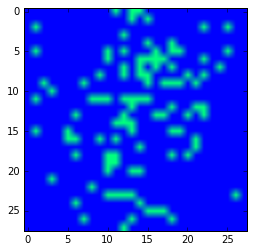

In [36]:
%matplotlib inline

from matplotlib import pylab

to_plot = np.asarray([0] * 784)
to_plot[selected_features] = 255
pylab.imshow(to_plot.reshape(28, 28), cmap='winter')
estimator.fit(X_test[:, selected_features], Y_test)
print(estimator.score(X_control[:, selected_features], Y_control))

# Качество распознавания 87,4%